In [ ]:
# -----------------------------------------------------------
import numpy as np, pandas as pd, torch, matplotlib.pyplot as plt
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.models import RecurrentNetwork       # 3‑layer LSTM
from pytorch_forecasting.data import GroupNormalizer
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss



def create_multivariate_dataset(seed: int = 42) -> pd.DataFrame:
    rng, rows = np.random.default_rng(seed), []
    for target in ["T1", "T2"]:
        for t in range(1, 1000):
            # base time index
            ti = t - 1
            #  T1: linear up + noise
            if target == "T1":
                target_val = 10 + 2 * t + rng.normal(0, 1)
            #  T2: increasing trend + sine + noise
            else:
                linear_trend = 5 + 0.5 * t
                sine_component = 10 * np.sin(2 * np.pi * t / 50)   # 50‑step period
                target_val = linear_trend + sine_component + rng.normal(0, 1)

            # X1 and X2 lines
            x1 = 5  + 0.5 * t + rng.normal(0, 0.2)
            x2 = 15 + 0.8 * t + rng.normal(0, 0.3)
            # X3: decreasing trend + sine + noise
            dec_trend   = 50 - 0.2 * t
            sine_exog   = 10 * np.sin(2 * np.pi * t / 30)      # 30‑step period
            x3 = dec_trend + sine_exog + rng.normal(0, 0.4)

            rows.append({
                "group_id": target,
                "time_idx": ti,
                "target":   target_val,
                "X1":       x1,
                "X2":       x2,
                "X3":       x3,
                "C1":       "A" if t <= 5 else "B"
            })
    return pd.DataFrame(rows)

# Example usage
df_long = create_multivariate_dataset()
print(df_long.head())
print(df_long.tail())

  group_id  time_idx     target        X1         X2         X3 C1
0       T1         0  12.304717  5.292003  16.025135  52.255343  A
1       T1         1  12.048965  5.739564  16.638352  53.540869  A
2       T1         2  15.983199  6.329391  17.663819  55.588969  A
3       T1         3  18.066031  7.225448  18.340253  56.287731  A
4       T1         4  20.368751  7.308223  19.263535  57.640284  A
     group_id  time_idx      target          X1          X2          X3 C1
1993       T2       994  496.354540  502.631744  811.473638 -140.392260  B
1994       T2       995  499.912176  502.877681  812.029229 -139.493789  B
1995       T2       996  498.750172  503.542762  812.602210 -139.796058  B
1996       T2       997  501.871104  504.029258  813.378224 -139.682212  B
1997       T2       998  503.156657  504.426460  814.241950 -140.547001  B


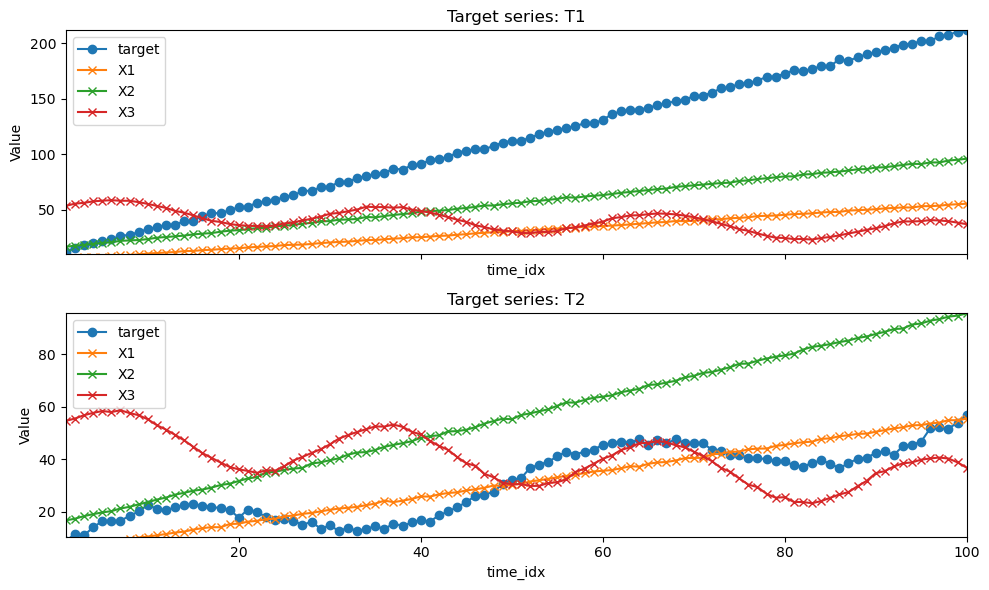

In [2]:
import matplotlib.pyplot as plt

# Get the unique target series (group_ids) from df_long
target_ids = df_long['group_id'].unique()

# Create subplots: one row per target series
fig, axes = plt.subplots(nrows=len(target_ids), figsize=(10, 6), sharex=True)

# If only one target, axes might not be an array, so ensure it's iterable
if len(target_ids) == 1:
    axes = [axes]

for ax, target in zip(axes, target_ids):
    subset = df_long[df_long['group_id'] == target]
    ax.plot(subset['time_idx'], subset['target'], label='target', marker='o')
    ax.plot(subset['time_idx'], subset['X1'], label='X1', marker='x')
    ax.plot(subset['time_idx'], subset['X2'], label='X2', marker='x')
    ax.plot(subset['time_idx'], subset['X3'], label='X3', marker='x')
    ax.set_title(f'Target series: {target}')
    ax.legend()
    ax.set_xlabel("time_idx")
    ax.set_ylabel("Value")


for ax in axes:
    ax.set_xlim(1, 100)
    # Get the target group from the title text (assumes title format "Target series: <group>")
    group = ax.get_title().split(":")[-1].strip()
    # Filter df_long for rows within the x limits and the current target group.
    filtered = df_long[(df_long['group_id'] == group) & (df_long['time_idx'].between(10, 100))]
    # Compute the min and max over the plotted columns.
    if not filtered.empty:
        y_min = filtered[['target', 'X1', 'X2', 'X3']].min().min()
        y_max = filtered[['target', 'X1', 'X2', 'X3']].max().max()
        ax.set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

In [3]:
# Train/validation/test split
cutoff_train = int(df_long.time_idx.max() * 0.70)
cutoff_val = int(df_long.time_idx.max() * 0.85)

train_df = df_long[df_long.time_idx <= cutoff_train]
val_df = df_long[(df_long.time_idx > cutoff_train) & (df_long.time_idx <= cutoff_val)]
test_df = df_long[df_long.time_idx > cutoff_val]

# TimeSeriesDataSet
enc_len, dec_len = 30, 10
common = dict(
    time_idx="time_idx",
    target="target",
    group_ids=["group_id"],
    min_encoder_length=enc_len,
    max_encoder_length=enc_len,
    min_prediction_length=dec_len,
    max_prediction_length=dec_len,
    time_varying_unknown_reals=["target"],
    time_varying_known_reals=["X1", "X2", "X3"],
    time_varying_known_categoricals=["C1"],
    target_normalizer=GroupNormalizer(groups=["group_id"])
)

train_ds = TimeSeriesDataSet(train_df, **common)
val_ds = TimeSeriesDataSet.from_dataset(train_ds, val_df, predict=True, stop_randomization=True)
test_ds = TimeSeriesDataSet.from_dataset(train_ds, test_df, predict=True, stop_randomization=True)

train_loader = train_ds.to_dataloader(train=True, batch_size=64, num_workers=0)
val_loader = val_ds.to_dataloader(train=False, batch_size=64, num_workers=0)
test_loader = test_ds.to_dataloader(train=False, batch_size=64, num_workers=0)

Notes:
- Here the X1,X2,X3 are considered known else we get error: Using "unknown" variables creates different encoder/decoder variable sets, which causes the assertion error. By using "known" variables, the same covariates are available to both encoder and decoder, satisfying the model's requirements.
- If you need truly unknown future covariates, consider using attention-based models like TemporalFusionTransformer instead of RecurrentNetwork.

In [4]:

# Get the first batch
x, y = next(iter(train_loader))

print("Batch structure:")
print(f"x (input dict) has {len(x)} keys")
print(f"y (target tuple) has {len(y)} elements")

print("\n3. DETAILED INPUT STRUCTURE (x):")
print("-" * 40)

# Analyze each component of the input dictionary x
for key, tensor in x.items():
    print(f"\n{key}:")
    print(f"  Shape: {tensor.shape}")
    print(f"  Data type: {tensor.dtype}")
    print(f"  Description:")

Batch structure:
x (input dict) has 11 keys
y (target tuple) has 2 elements

3. DETAILED INPUT STRUCTURE (x):
----------------------------------------

encoder_cat:
  Shape: torch.Size([64, 30, 1])
  Data type: torch.int64
  Description:

encoder_cont:
  Shape: torch.Size([64, 30, 4])
  Data type: torch.float32
  Description:

encoder_target:
  Shape: torch.Size([64, 30])
  Data type: torch.float32
  Description:

encoder_lengths:
  Shape: torch.Size([64])
  Data type: torch.int64
  Description:

decoder_cat:
  Shape: torch.Size([64, 10, 1])
  Data type: torch.int64
  Description:

decoder_cont:
  Shape: torch.Size([64, 10, 4])
  Data type: torch.float32
  Description:

decoder_target:
  Shape: torch.Size([64, 10])
  Data type: torch.float32
  Description:

decoder_lengths:
  Shape: torch.Size([64])
  Data type: torch.int64
  Description:

decoder_time_idx:
  Shape: torch.Size([64, 10])
  Data type: torch.int64
  Description:

groups:
  Shape: torch.Size([64, 1])
  Data type: torch.int

In [5]:

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor(logging_interval="epoch")

trainer = Trainer(
    max_epochs=50,
    accelerator="auto",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[lr_logger, early_stop_callback],
    limit_train_batches=50,
    enable_progress_bar=True,
)

model = RecurrentNetwork.from_dataset(
    train_ds,
    cell_type="LSTM",
    hidden_size=64,
    rnn_layers=3,
    dropout=0.1,
    learning_rate=0.001,
)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\akashv22\AppData\Local\anaconda3\envs\fc_env\lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
c:\Users\akashv22\AppData\Local\anaconda3\envs\fc_env\lib\site-packages\lightning\pytorch\utilities\parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using

In [ ]:

trainer.fit(model, train_loader, val_loader)

# Predictions and evaluation
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = RecurrentNetwork.load_from_checkpoint(best_model_path)

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type           | Params
----------------------------------------------------
0 | loss             | MAE            | 0     
1 | logging_metrics  | ModuleList     | 0     
2 | embeddings       | MultiEmbedding | 2     
3 | rnn              | LSTM           | 84.7 K
4 | output_projector | Linear         | 65    
----------------------------------------------------
84.8 K    Trainable params
0         Non-trainable params
84.8 K    Total params
0.339     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\akashv22\AppData\Local\anaconda3\envs\fc_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\akashv22\AppData\Local\anaconda3\envs\fc_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\akashv22\AppData\Local\anaconda3\envs\fc_env\lib\site-packages\lightning\pytorch\loops\fit_loop.py:281: PossibleUserWarning: The number of training b

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:

# Predictions and evaluation
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = RecurrentNetwork.load_from_checkpoint(best_model_path)

# Validation predictions
val_predictions = best_model.predict(val_loader, return_y=True)
val_mae = MAE()(val_predictions.output, val_predictions.y)
val_smape = SMAPE()(val_predictions.output, val_predictions.y)

print(f"Validation MAE: {val_mae:.3f}")
print(f"Validation SMAPE: {val_smape:.3f}")

# Test predictions
test_predictions = best_model.predict(test_loader, return_y=True)
test_mae = MAE()(test_predictions.output, test_predictions.y)
test_smape = SMAPE()(test_predictions.output, test_predictions.y)

print(f"Test MAE: {test_mae:.3f}")
print(f"Test SMAPE: {test_smape:.3f}")

# Plot predictions for first few samples
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for idx in range(min(4, len(test_predictions.y))):
    ax = axes[idx]
    
    # Get actual and predicted values
    y_actual = test_predictions.y[idx].cpu().numpy()
    y_pred = test_predictions.output[idx].cpu().numpy()
    
    # Plot
    ax.plot(y_actual, label='Actual', linewidth=2)
    ax.plot(y_pred, label='Predicted', linewidth=2, linestyle='--')
    ax.set_title(f'Sample {idx+1}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show model summary
print(f"\nModel: {model}")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")